**Data Generator Script**

This script simulates the generation of time-based data and saves it to a CSV file. It creates random but realistic values for different parameters at regular intervals and stores them for later use. The script is useful for testing, prototyping, or simulating real-time data collection .

In [ ]:
import time
import random
import math
import csv
import os
from threading import Event
from collections import deque

class EmissionDataGenerator:
    def __init__(self, csv_filename='emission_data.csv'):
        # Initialize the generator, prepare CSV file and data buffer
        self.stop_event = Event()
        self.csv_filename = csv_filename
        self.data_buffer = deque(maxlen=1000)
        self._init_csv_file()

    def _init_csv_file(self):
        if not os.path.exists(self.csv_filename):
            with open(self.csv_filename, 'w', newline='') as f:
                writer = csv.DictWriter(f, fieldnames=['timestamp', 'co2_ppm', 'temperature', 'humidity'])
                writer.writeheader()

    def generate_data_point(self):
        # Generate a single data point with realistic CO2, temperature, and humidity values
        hour = (time.time() % 86400) / 3600
        seasonality = 50 * math.sin(2 * math.pi * hour / 24)
        co2_ppm = 400 + seasonality + random.gauss(0, 5)

        # Occasionally simulate a CO2 spike
        if random.random() < 0.05:
            co2_ppm += random.uniform(100, 300)

        return {
            "timestamp": time.time(),
            "co2_ppm": co2_ppm,
            "temperature": 25 + random.gauss(0, 0.5),
            "humidity": 60 + random.gauss(0, 2)
        }

    def run(self, duration_sec=60):
        # Run the generator for a given number of seconds and write data to CSV
        start_time = time.time()

        with open(self.csv_filename, 'a', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=['timestamp', 'co2_ppm', 'temperature', 'humidity'])

            while not self.stop_event.is_set():
                if (time.time() - start_time) > duration_sec:
                    break

                data = self.generate_data_point()
                self.data_buffer.append(data)
                writer.writerow(data)
                f.flush()

                print(f"Generated: {data}")
                time.sleep(1)

    def stop(self):
        # Stop the data generation loop
        self.stop_event.set()

if __name__ == "__main__":
    # Run the generator for 180 seconds 
    generator = EmissionDataGenerator()
    print("Starting generation for 180 seconds...")
    generator.run(duration_sec=180)
    generator.stop()
    print(f"Data saved to {generator.csv_filename}")
    print(f"{len(generator.data_buffer)} points generated")


**Data  Cleaning and Preprocessing**

This Python code implements a system that continuously reads and processes simulated data points from a CSV file in real time. Each data point includes values such as CO2 concentration, temperature, and humidity. The program validates data structure and value ranges, detects and removes duplicates, and handles missing values through imputation using recent data and running statistics. It updates statistics incrementally and applies advanced imputation once enough data is gathered. Cleaned and validated data points are saved to a separate CSV file, ensuring reliable and consistent data quality for further analysis or processing.

In [ ]:
import time
import csv
import os
from collections import deque
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

class RealTimeDataPreprocessor:
    def __init__(self, max_missing_threshold=0.3, window_size=30):
        # Initializes configuration parameters, imputer, and running statistics
        self.window_size = window_size
        self.max_missing_threshold = max_missing_threshold
        self.data_buffer = deque(maxlen=1000)
        self.last_timestamp = None

        self.valid_ranges = {
            'co2_ppm': (300, 2000),
            'temperature': (10, 40),
            'humidity': (0, 100)
        }

        self.imputer = SimpleImputer(strategy='mean')
        self.imputer_fitted = False
        self.running_stats = {
            'co2_ppm': {'mean': 400, 'std': 50, 'count': 0},
            'temperature': {'mean': 25, 'std': 5, 'count': 0},
            'humidity': {'mean': 60, 'std': 10, 'count': 0}
        }

    def process_data_point(self, data_point):
        # Main method to process a single data point and apply validation and imputation
        if self._is_duplicate(data_point):
            return None

        if not self._validate_structure(data_point):
            return None

        clean_point = self._handle_missing_values(data_point)
        if clean_point is None:
            return None

        if not self._validate_ranges(clean_point):
            return None

        self._update_running_stats(clean_point)
        final_point = self._final_imputation(clean_point)

        self.data_buffer.append(final_point)
        self.last_timestamp = final_point['timestamp']
        return final_point

    def _is_duplicate(self, data_point):
        # Checks whether the data point is a duplicate based on timestamp
        return self.last_timestamp is not None and data_point['timestamp'] == self.last_timestamp

    def _validate_structure(self, data_point):
        # Ensures the data point contains all required keys
        required_keys = {'timestamp', 'co2_ppm', 'temperature', 'humidity'}
        return all(key in data_point for key in required_keys)

    def _handle_missing_values(self, data_point):
        # Handles missing values using local neighbors or running mean
        missing_count = sum(1 for k in ['co2_ppm', 'temperature', 'humidity']
                            if pd.isna(data_point.get(k)))
        if missing_count / 3 > self.max_missing_threshold:
            return None

        clean_point = data_point.copy()
        k = 4

        if len(self.data_buffer) == 0:
            for feature in ['co2_ppm', 'temperature', 'humidity']:
                if pd.isna(clean_point.get(feature)):
                    clean_point[feature] = self.running_stats[feature]['mean']
            return clean_point

        df_buffer = pd.DataFrame(self.data_buffer)

        for feature in ['co2_ppm', 'temperature', 'humidity']:
            if pd.isna(clean_point.get(feature)):
                current_time = clean_point['timestamp']
                df_buffer['time_diff'] = (df_buffer['timestamp'] - current_time).abs()
                df_valid = df_buffer[df_buffer[feature].notna()]
                df_sorted = df_valid.sort_values('time_diff')
                neighbors = df_sorted.head(k)[feature]

                if len(neighbors) > 0:
                    clean_point[feature] = neighbors.mean()
                else:
                    clean_point[feature] = self.running_stats[feature]['mean']

                df_buffer.drop(columns=['time_diff'], inplace=True)

        return clean_point

    def _validate_ranges(self, data_point):
        # Validates if the data point values fall within acceptable ranges
        for feature, (min_val, max_val) in self.valid_ranges.items():
            value = data_point.get(feature)
            if value is not None and not (min_val <= value <= max_val):
                return False
        return True

    def _update_running_stats(self, data_point):
        # Updates the mean and standard deviation for each feature incrementally
        for feature in ['co2_ppm', 'temperature', 'humidity']:
            value = data_point[feature]
            stats = self.running_stats[feature]
            stats['count'] += 1
            delta = value - stats['mean']
            stats['mean'] += delta / stats['count']
            delta2 = value - stats['mean']
            stats['std'] += delta * delta2

    def _final_imputation(self, data_point):
        # Applies final imputation using a fitted scikit-learn SimpleImputer
        final_point = data_point.copy()
        if not self.imputer_fitted and len(self.data_buffer) >= self.window_size:
            self._fit_imputer()
        if self.imputer_fitted:
            arr = np.array([[final_point['co2_ppm'], final_point['temperature'], final_point['humidity']]])
            imputed = self.imputer.transform(arr)
            final_point['co2_ppm'], final_point['temperature'], final_point['humidity'] = imputed[0]
        return final_point

    def _fit_imputer(self):
        # Trains the imputer using the last N data points
        df = pd.DataFrame(list(self.data_buffer)[-self.window_size:])
        self.imputer.fit(df[['co2_ppm', 'temperature', 'humidity']])
        self.imputer_fitted = True


def realtime_csv_processor(csv_file, preprocessor, cleaned_csv='cleaned_emission_data.csv', polling_interval=1):
    # Continuously monitors and processes new lines in the CSV file in real time
    last_line = 0
    print(f"Début du traitement en temps réel du fichier {csv_file}")

    if not os.path.exists(cleaned_csv):
        with open(cleaned_csv, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=['timestamp', 'co2_ppm', 'temperature', 'humidity'])
            writer.writeheader()

    while True:
        if not os.path.exists(csv_file):
            print("Fichier source non trouvé, attente...")
            time.sleep(polling_interval)
            continue

        try:
            with open(csv_file, 'r') as f:
                lines = f.readlines()
        except Exception as e:
            print("Erreur lecture fichier:", e)
            time.sleep(polling_interval)
            continue

        new_lines = lines[last_line:]
        if len(new_lines) == 0:
            time.sleep(polling_interval)
            continue

        if last_line == 0 and new_lines[0].startswith('timestamp'):
            new_lines = new_lines[1:]

        for line in new_lines:
            parts = line.strip().split(',')
            if len(parts) != 4:
                print("Ligne mal formée ignorée:", line)
                continue
            try:
                data_point = {
                    'timestamp': float(parts[0]),
                    'co2_ppm': float(parts[1]),
                    'temperature': float(parts[2]),
                    'humidity': float(parts[3])
                }
            except ValueError:
                print("Erreur conversion ligne ignorée:", line)
                continue

            processed = preprocessor.process_data_point(data_point)
            if processed:
                print("Donnée traitée:", processed)
                with open(cleaned_csv, 'a', newline='') as f_clean:
                    writer = csv.DictWriter(f_clean, fieldnames=['timestamp', 'co2_ppm', 'temperature', 'humidity'])
                    writer.writerow(processed)
            else:
                print("Donnée rejetée:", data_point)

        last_line += len(new_lines)
        time.sleep(polling_interval)


if __name__ == "__main__":
    csv_filename = "emission_data.csv"
    cleaned_filename = "cleaned_emission_data.csv"
    preprocessor = RealTimeDataPreprocessor()
    realtime_csv_processor(csv_filename, preprocessor, cleaned_csv=cleaned_filename)


Début du traitement en temps réel du fichier emission_data.csv
Donnée traitée: {'timestamp': 1749232460.9441226, 'co2_ppm': 353.81771881858504, 'temperature': 24.92580471843228, 'humidity': 57.26586039579435}
Donnée traitée: {'timestamp': 1749232461.9445393, 'co2_ppm': 347.69287924296015, 'temperature': 23.975750719521937, 'humidity': 60.106387629795876}
Donnée traitée: {'timestamp': 1749232462.945247, 'co2_ppm': 352.1933371881465, 'temperature': 25.131944468723578, 'humidity': 61.027999530912474}
Donnée traitée: {'timestamp': 1749232463.9459312, 'co2_ppm': 359.13136777898745, 'temperature': 25.837085947489502, 'humidity': 62.59476305584954}
Donnée traitée: {'timestamp': 1749232464.9467795, 'co2_ppm': 347.38979946868164, 'temperature': 25.70763162210924, 'humidity': 61.510145129363586}
Donnée traitée: {'timestamp': 1749232465.9477446, 'co2_ppm': 348.19825028752877, 'temperature': 24.99342999980472, 'humidity': 59.76228668396494}
Donnée traitée: {'timestamp': 1749232466.9483466, 'co2_pp

C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packag

Donnée traitée: {'timestamp': 1749232619.2782314, 'co2_ppm': 354.0431931065015, 'temperature': 25.064670265610324, 'humidity': 61.10800454058878}
Donnée traitée: {'timestamp': 1749232620.278936, 'co2_ppm': 348.5934194019147, 'temperature': 24.462034971802307, 'humidity': 62.83113323281416}
Donnée traitée: {'timestamp': 1749232621.2923753, 'co2_ppm': 344.18559320042925, 'temperature': 25.72865755271548, 'humidity': 57.178753693225126}
Donnée traitée: {'timestamp': 1749232622.2951336, 'co2_ppm': 347.20772809761627, 'temperature': 26.06309475161742, 'humidity': 59.826739201290025}
Donnée traitée: {'timestamp': 1749232623.2956355, 'co2_ppm': 349.1408064793137, 'temperature': 24.525265943470476, 'humidity': 57.76203096422591}
Donnée traitée: {'timestamp': 1749232624.2964573, 'co2_ppm': 351.2021926916145, 'temperature': 25.09435724030231, 'humidity': 62.85836487409583}
Donnée traitée: {'timestamp': 1749232625.297187, 'co2_ppm': 354.17538788655753, 'temperature': 24.237666292720387, 'humidity

C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packag

Donnée traitée: {'timestamp': 1749232896.2444766, 'co2_ppm': 609.185780710874, 'temperature': 24.034224401079644, 'humidity': 63.318788145082564}
Donnée traitée: {'timestamp': 1749232897.2452168, 'co2_ppm': 342.7367189754658, 'temperature': 25.47298095240899, 'humidity': 61.85646740913355}
Donnée traitée: {'timestamp': 1749232898.2462356, 'co2_ppm': 545.5906018071543, 'temperature': 25.324654284361856, 'humidity': 60.53178708981528}
Donnée traitée: {'timestamp': 1749232899.2481863, 'co2_ppm': 496.39349585893, 'temperature': 25.462830707542697, 'humidity': 62.3653711849488}
Donnée traitée: {'timestamp': 1749232900.2489402, 'co2_ppm': 344.9842877699558, 'temperature': 25.632099683956692, 'humidity': 57.358209156533974}
Donnée traitée: {'timestamp': 1749232901.249605, 'co2_ppm': 350.06005061397246, 'temperature': 24.961391030835223, 'humidity': 61.04033498596572}
Donnée traitée: {'timestamp': 1749232902.260719, 'co2_ppm': 339.4305665118558, 'temperature': 24.92041369254875, 'humidity': 59

C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packag

Donnée traitée: {'timestamp': 1749233248.5320668, 'co2_ppm': 347.29965214802, 'temperature': 25.175113502867237, 'humidity': 59.40760800972238}
Donnée traitée: {'timestamp': 1749233249.5354154, 'co2_ppm': 350.53992722527545, 'temperature': 25.489323499547517, 'humidity': 57.83960836222458}
Donnée traitée: {'timestamp': 1749233250.5379882, 'co2_ppm': 348.1612868438553, 'temperature': 25.02573638303659, 'humidity': 59.69750257720138}
Donnée traitée: {'timestamp': 1749233251.5407767, 'co2_ppm': 356.59620476354246, 'temperature': 24.499267934957057, 'humidity': 58.05961177627025}
Donnée traitée: {'timestamp': 1749233252.5423071, 'co2_ppm': 361.6646357902694, 'temperature': 25.49113537438549, 'humidity': 60.47402590886117}
Donnée traitée: {'timestamp': 1749233253.546167, 'co2_ppm': 352.58346879916013, 'temperature': 25.022780805253625, 'humidity': 61.97718513109802}
Donnée traitée: {'timestamp': 1749233254.549403, 'co2_ppm': 477.1901720768979, 'temperature': 24.27109073143415, 'humidity': 6

C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packag

Donnée traitée: {'timestamp': 1749233302.7448533, 'co2_ppm': 354.6437741480375, 'temperature': 24.44887703929475, 'humidity': 58.111467995212124}
Donnée traitée: {'timestamp': 1749233303.7457817, 'co2_ppm': 353.76591878204374, 'temperature': 24.611254983928404, 'humidity': 62.72719475295064}
Donnée traitée: {'timestamp': 1749233304.7465694, 'co2_ppm': 354.03967449784216, 'temperature': 24.818671227136797, 'humidity': 59.756033937595916}
Donnée traitée: {'timestamp': 1749233305.7480433, 'co2_ppm': 347.15584875367614, 'temperature': 25.628514414810297, 'humidity': 61.9919119322749}
Donnée traitée: {'timestamp': 1749233306.7487931, 'co2_ppm': 345.45062755788064, 'temperature': 25.362890126219103, 'humidity': 60.31138222074013}
Donnée traitée: {'timestamp': 1749233307.7695572, 'co2_ppm': 340.93151050893084, 'temperature': 24.876084792089188, 'humidity': 58.46284324179061}
Donnée traitée: {'timestamp': 1749233308.7748382, 'co2_ppm': 350.1781645940182, 'temperature': 24.54930131357042, 'humi

C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packag

Donnée traitée: {'timestamp': 1749233452.2870395, 'co2_ppm': 345.5550076934542, 'temperature': 25.009600691868094, 'humidity': 61.56082859529049}
Donnée traitée: {'timestamp': 1749233453.2874649, 'co2_ppm': 350.37489694199763, 'temperature': 24.16684615642599, 'humidity': 59.16858766623302}
Donnée traitée: {'timestamp': 1749233454.2921212, 'co2_ppm': 352.2555036658617, 'temperature': 24.877865863793232, 'humidity': 61.72073053326682}
Donnée traitée: {'timestamp': 1749233455.2931046, 'co2_ppm': 354.2309816824611, 'temperature': 25.553864318494156, 'humidity': 57.12271585662057}
Donnée traitée: {'timestamp': 1749233456.2946012, 'co2_ppm': 354.1861869660458, 'temperature': 24.74470544938862, 'humidity': 61.11982385562511}
Donnée traitée: {'timestamp': 1749233457.2961135, 'co2_ppm': 345.303024071768, 'temperature': 24.268459504563825, 'humidity': 60.338184908855816}
Donnée traitée: {'timestamp': 1749233458.2970374, 'co2_ppm': 350.82140800571307, 'temperature': 24.931288416128112, 'humidity

C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packag

Donnée traitée: {'timestamp': 1749233566.5192945, 'co2_ppm': 346.9311131335025, 'temperature': 24.92373577023918, 'humidity': 52.51829041006135}
Donnée traitée: {'timestamp': 1749233567.5221386, 'co2_ppm': 344.7892884444812, 'temperature': 24.28560319062168, 'humidity': 62.51894916655116}
Donnée traitée: {'timestamp': 1749233568.5230753, 'co2_ppm': 343.9512506172336, 'temperature': 24.73279499864421, 'humidity': 58.61875301477364}
Donnée traitée: {'timestamp': 1749233569.5265317, 'co2_ppm': 342.8696880454311, 'temperature': 24.108394710418636, 'humidity': 59.70689576416351}
Donnée traitée: {'timestamp': 1749233570.5285823, 'co2_ppm': 347.9772993508348, 'temperature': 23.73933844602312, 'humidity': 62.11563373286525}
Donnée traitée: {'timestamp': 1749233571.5295, 'co2_ppm': 342.1473873849535, 'temperature': 24.655380991948988, 'humidity': 59.94518852247874}
Donnée traitée: {'timestamp': 1749233572.5308478, 'co2_ppm': 353.3133970743019, 'temperature': 25.06257409816033, 'humidity': 62.18

C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packag

Donnée traitée: {'timestamp': 1749234218.0928566, 'co2_ppm': 351.0499518722365, 'temperature': 24.002001502828794, 'humidity': 58.138251323118325}
Donnée traitée: {'timestamp': 1749234219.0932658, 'co2_ppm': 355.42570572414894, 'temperature': 24.701714573903434, 'humidity': 60.357878048825334}
Donnée traitée: {'timestamp': 1749234220.0935414, 'co2_ppm': 344.2174826880838, 'temperature': 24.752518364392184, 'humidity': 55.52409777658093}
Donnée traitée: {'timestamp': 1749234221.0943646, 'co2_ppm': 355.12114361212565, 'temperature': 24.27222172384774, 'humidity': 59.98041156018631}
Donnée traitée: {'timestamp': 1749234222.0948412, 'co2_ppm': 359.7609326576894, 'temperature': 24.63060159893743, 'humidity': 56.56232317911266}
Donnée traitée: {'timestamp': 1749234223.0955272, 'co2_ppm': 359.4054877738544, 'temperature': 25.035511225400516, 'humidity': 60.59356206500045}
Donnée traitée: {'timestamp': 1749234224.0965302, 'co2_ppm': 357.98786021725095, 'temperature': 24.644734988133525, 'humid

C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packag

Donnée traitée: {'timestamp': 1749235396.4014423, 'co2_ppm': 349.2478264354764, 'temperature': 25.624008259486864, 'humidity': 58.5360103564791}
Donnée traitée: {'timestamp': 1749235397.401816, 'co2_ppm': 347.21035043036824, 'temperature': 24.803687766521215, 'humidity': 61.77608904677228}
Donnée traitée: {'timestamp': 1749235398.4025712, 'co2_ppm': 534.0684949255239, 'temperature': 26.49499028199129, 'humidity': 63.52622930950302}
Donnée traitée: {'timestamp': 1749235399.4030743, 'co2_ppm': 356.22246940846065, 'temperature': 25.41082472982299, 'humidity': 57.1984512643481}
Donnée traitée: {'timestamp': 1749235400.4037387, 'co2_ppm': 351.9122848549723, 'temperature': 25.788293454927103, 'humidity': 57.26412035824031}
Donnée traitée: {'timestamp': 1749235401.4040968, 'co2_ppm': 339.0419844278804, 'temperature': 25.359296195764717, 'humidity': 61.61371221626718}
Donnée traitée: {'timestamp': 1749235402.4043853, 'co2_ppm': 349.06230555652894, 'temperature': 25.814082295089754, 'humidity':

C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packag

Donnée traitée: {'timestamp': 1749235473.4424355, 'co2_ppm': 573.113815518504, 'temperature': 24.927167748478116, 'humidity': 61.37907746983593}
Donnée traitée: {'timestamp': 1749235474.4430225, 'co2_ppm': 352.2826461404463, 'temperature': 25.11213494351291, 'humidity': 59.91775390213666}
Donnée traitée: {'timestamp': 1749235475.4436874, 'co2_ppm': 351.09093379519373, 'temperature': 24.442553621606294, 'humidity': 62.88216976768119}
Donnée traitée: {'timestamp': 1749235476.4441943, 'co2_ppm': 349.37822686869043, 'temperature': 24.854156865175938, 'humidity': 59.51471665703165}
Donnée traitée: {'timestamp': 1749235477.4447017, 'co2_ppm': 358.7932637001402, 'temperature': 25.362254972749984, 'humidity': 59.74130157017335}
Donnée traitée: {'timestamp': 1749235478.4455285, 'co2_ppm': 339.2153901581583, 'temperature': 25.153702775598457, 'humidity': 58.44795081645931}
Donnée traitée: {'timestamp': 1749235479.4459474, 'co2_ppm': 350.4845358304964, 'temperature': 24.28613192285196, 'humidity'

C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packag

Donnée traitée: {'timestamp': 1749237980.6238608, 'co2_ppm': 347.32564403747136, 'temperature': 24.386235008692125, 'humidity': 59.08740720382767}
Donnée traitée: {'timestamp': 1749237981.6244214, 'co2_ppm': 632.6361460180439, 'temperature': 25.064834399480052, 'humidity': 60.62861096243233}
Donnée traitée: {'timestamp': 1749237982.6251354, 'co2_ppm': 352.1407735407586, 'temperature': 25.616318978246422, 'humidity': 62.38229456481959}
Donnée traitée: {'timestamp': 1749237983.6259975, 'co2_ppm': 355.8563871783945, 'temperature': 24.653981403620485, 'humidity': 63.351703703328454}
Donnée traitée: {'timestamp': 1749237984.626894, 'co2_ppm': 344.8967906069327, 'temperature': 25.123522584030866, 'humidity': 62.47716275788986}
Donnée traitée: {'timestamp': 1749237985.6277447, 'co2_ppm': 357.4715262137781, 'temperature': 24.9410958461607, 'humidity': 61.194766184571485}
Donnée traitée: {'timestamp': 1749237986.628211, 'co2_ppm': 354.65300367432866, 'temperature': 24.655532917439878, 'humidity

C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packag

Donnée traitée: {'timestamp': 1749238071.685697, 'co2_ppm': 353.58193046859435, 'temperature': 24.84580564140912, 'humidity': 61.080686017399366}
Donnée traitée: {'timestamp': 1749238072.686395, 'co2_ppm': 353.1615463558324, 'temperature': 25.178800245593727, 'humidity': 61.41094425202024}
Donnée traitée: {'timestamp': 1749238073.6869435, 'co2_ppm': 351.69150181249455, 'temperature': 25.487109410693357, 'humidity': 57.668850137490104}
Donnée traitée: {'timestamp': 1749238074.6877146, 'co2_ppm': 347.8270055810896, 'temperature': 24.891549467124815, 'humidity': 62.72840021847627}
Donnée traitée: {'timestamp': 1749238075.6883235, 'co2_ppm': 353.0165052015783, 'temperature': 25.197317639932887, 'humidity': 59.4805934343635}
Donnée traitée: {'timestamp': 1749238076.688774, 'co2_ppm': 358.26087724381534, 'temperature': 24.67311288611354, 'humidity': 59.15155286505668}
Donnée traitée: {'timestamp': 1749238077.6893754, 'co2_ppm': 353.0621000836202, 'temperature': 25.17514515991413, 'humidity':

C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packag

Donnée traitée: {'timestamp': 1749238164.0230372, 'co2_ppm': 353.935373518617, 'temperature': 25.441483302010884, 'humidity': 59.660089007894946}
Donnée traitée: {'timestamp': 1749238165.0236475, 'co2_ppm': 358.269608094539, 'temperature': 24.592960940480456, 'humidity': 57.566798824443175}
Donnée traitée: {'timestamp': 1749238166.0240836, 'co2_ppm': 357.6105377070642, 'temperature': 25.500752388049367, 'humidity': 58.19430051653598}
Donnée traitée: {'timestamp': 1749238167.0246599, 'co2_ppm': 358.15679759162794, 'temperature': 24.90156894822761, 'humidity': 57.19289262502308}
Donnée traitée: {'timestamp': 1749238168.0251803, 'co2_ppm': 347.7165466068515, 'temperature': 25.17411304023683, 'humidity': 57.70942138200269}
Donnée traitée: {'timestamp': 1749238169.0257947, 'co2_ppm': 344.5890330413419, 'temperature': 25.76271898369629, 'humidity': 60.61227495193092}
Donnée traitée: {'timestamp': 1749238170.026577, 'co2_ppm': 354.63308203005954, 'temperature': 25.52167129871495, 'humidity': 

C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packag

Donnée traitée: {'timestamp': 1749238247.0724053, 'co2_ppm': 360.8464478109428, 'temperature': 24.74886260657305, 'humidity': 57.94327057019494}
Donnée traitée: {'timestamp': 1749238248.0728557, 'co2_ppm': 357.9888841384236, 'temperature': 25.317100638720625, 'humidity': 58.84040383027867}
Donnée traitée: {'timestamp': 1749238249.0737147, 'co2_ppm': 356.92090510353086, 'temperature': 25.102248042701476, 'humidity': 57.677523683283326}
Donnée traitée: {'timestamp': 1749238250.0742319, 'co2_ppm': 359.83582357379527, 'temperature': 24.607199910967296, 'humidity': 59.704448030046954}
Donnée traitée: {'timestamp': 1749238251.075001, 'co2_ppm': 352.79035523989484, 'temperature': 25.165345931872565, 'humidity': 62.7308157285795}
Donnée traitée: {'timestamp': 1749238252.075406, 'co2_ppm': 362.1872399233865, 'temperature': 24.613375819145066, 'humidity': 59.83395710395782}
Donnée traitée: {'timestamp': 1749238253.0755699, 'co2_ppm': 349.67065290868067, 'temperature': 24.85596708366599, 'humidit

C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packag

Donnée traitée: {'timestamp': 1749238331.118823, 'co2_ppm': 355.9367564458421, 'temperature': 25.518568683741343, 'humidity': 56.79213486144177}
Donnée traitée: {'timestamp': 1749238332.1192594, 'co2_ppm': 351.9729959934708, 'temperature': 24.459935499390067, 'humidity': 61.412182782024374}
Donnée traitée: {'timestamp': 1749238333.1200125, 'co2_ppm': 352.4286165571726, 'temperature': 24.866634153024318, 'humidity': 59.27638530543256}
Donnée traitée: {'timestamp': 1749299643.2359507, 'co2_ppm': 392.5255256243133, 'temperature': 24.720711921945608, 'humidity': 58.35668694119142}
Donnée traitée: {'timestamp': 1749299644.2395024, 'co2_ppm': 393.1691523642248, 'temperature': 24.773242967968276, 'humidity': 59.872589219042375}
Donnée traitée: {'timestamp': 1749299645.2405179, 'co2_ppm': 387.24799400148527, 'temperature': 25.747306162196107, 'humidity': 59.548751470282475}
Donnée traitée: {'timestamp': 1749299646.2417693, 'co2_ppm': 398.7212214761976, 'temperature': 25.420476528593024, 'humid

C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\rouat\anaconda3\Lib\site-packag

Donnée traitée: {'timestamp': 1749299736.3540843, 'co2_ppm': 382.53524699824476, 'temperature': 24.395810821719863, 'humidity': 60.82534011732897}
Donnée traitée: {'timestamp': 1749299737.3546875, 'co2_ppm': 387.39450986007427, 'temperature': 25.464681234938382, 'humidity': 61.09776456425579}
Donnée traitée: {'timestamp': 1749299738.3552053, 'co2_ppm': 392.0549085411636, 'temperature': 24.476394355862165, 'humidity': 58.19598514253344}
Donnée traitée: {'timestamp': 1749299739.356273, 'co2_ppm': 390.6436049743536, 'temperature': 24.972918115496775, 'humidity': 60.00221756152336}
Donnée traitée: {'timestamp': 1749299740.357022, 'co2_ppm': 397.89217795073114, 'temperature': 24.41069888426608, 'humidity': 58.842951070967594}
Donnée traitée: {'timestamp': 1749299741.3576765, 'co2_ppm': 394.61211675109433, 'temperature': 25.939167470666515, 'humidity': 57.60657931597959}
Donnée traitée: {'timestamp': 1749299742.3585086, 'co2_ppm': 392.9591096762972, 'temperature': 24.701483328471667, 'humidi

KeyboardInterrupt: 

**Improved LSTM Autoencoder Design and Anomaly Detection**

The original LSTM Autoencoder had mismatched encoder-decoder structures and lacked a proper training loop. The corrected model uses an autoregressive decoder that generates the output sequence step-by-step, with hidden states passed from the encoder and a linear layer mapping to the input dimension. The training loop includes batch processing, MSE loss, and early stopping. Data is preprocessed by scaling and segmenting into fixed-length sequences. After training, anomalies are detected by calculating reconstruction errors and flagging sequences that exceed a statistically defined threshold

Epoch 1/50 - Train Loss: 0.993203 - Val Loss: 0.937517
Epoch 2/50 - Train Loss: 0.990331 - Val Loss: 0.928210
Epoch 3/50 - Train Loss: 0.978010 - Val Loss: 0.925607
Epoch 4/50 - Train Loss: 0.975511 - Val Loss: 0.922990
Epoch 5/50 - Train Loss: 0.972065 - Val Loss: 0.917589
Epoch 6/50 - Train Loss: 0.960082 - Val Loss: 0.905405
Epoch 7/50 - Train Loss: 0.948409 - Val Loss: 0.896317
Epoch 8/50 - Train Loss: 0.936300 - Val Loss: 0.882764
Epoch 9/50 - Train Loss: 0.924612 - Val Loss: 0.869998
Epoch 10/50 - Train Loss: 0.907503 - Val Loss: 0.862581
Epoch 11/50 - Train Loss: 0.881334 - Val Loss: 0.816774
Epoch 12/50 - Train Loss: 0.862958 - Val Loss: 0.810166
Epoch 13/50 - Train Loss: 0.835540 - Val Loss: 0.794171
Epoch 14/50 - Train Loss: 0.848684 - Val Loss: 0.798183
Epoch 15/50 - Train Loss: 0.807788 - Val Loss: 0.784978
Epoch 16/50 - Train Loss: 0.800668 - Val Loss: 0.748183
Epoch 17/50 - Train Loss: 0.784687 - Val Loss: 0.735959
Epoch 18/50 - Train Loss: 0.788362 - Val Loss: 0.734253
E

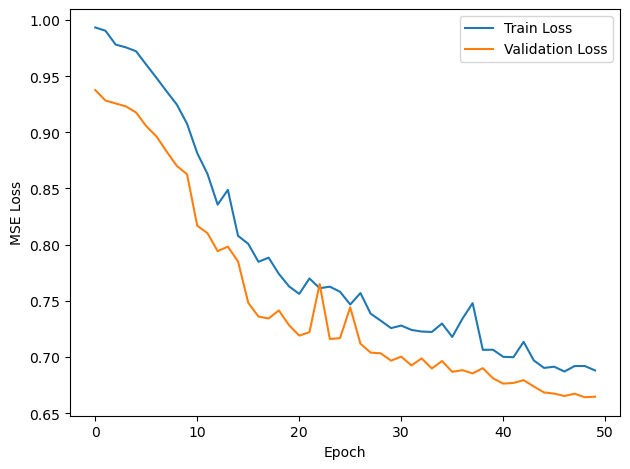

Seuil d'anomalie: 1.926944
Nombre d'anomalies détectées: 19


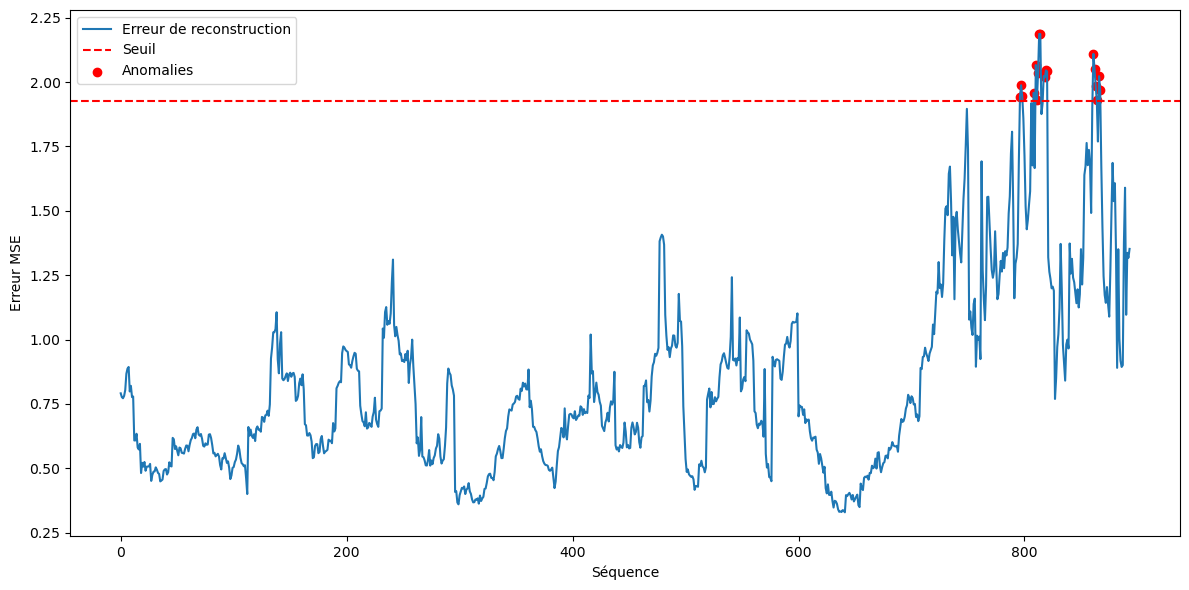

In [5]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Prepare sequences of fixed length from the time series data
def prepare_data(data, seq_len):
    sequences = []
    for i in range(len(data) - seq_len):
        seq = data[i:i+seq_len]
        sequences.append(seq)
    return np.array(sequences)

# Define the LSTM Autoencoder model with an autoregressive decoder and dropout
class LSTM_AE(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, seq_len, dropout=0.2):
        super(LSTM_AE, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, input_dim)
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

    # Forward pass through encoder and autoregressive decoder to reconstruct input sequence
    def forward(self, x):
        batch_size = x.size(0)
        _, (h_n, c_n) = self.encoder(x)
        decoder_input = torch.zeros(batch_size, 1, self.hidden_dim).to(x.device)
        hidden = (h_n, c_n)
        outputs = []
        for _ in range(self.seq_len):
            out, hidden = self.decoder(decoder_input, hidden)
            out_linear = self.linear(out)
            outputs.append(out_linear)
            decoder_input = out
        outputs = torch.cat(outputs, dim=1)
        return outputs

# Train the model using training and validation data loaders, with an early stopping
def train_model(model, train_loader, val_loader, epochs, lr, early_stopping=False, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            x = batch[0].to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, x)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                x = batch[0].to(device)
                output = model(x)
                loss = criterion(output, x)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}")

        if early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping déclenché.")
                    break

    return train_losses, val_losses

# Detect anomalies by computing reconstruction errors and identifying sequences exceeding a threshold
def detect_anomalies(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)
    errors = []

    with torch.no_grad():
        for batch in data_loader:
            x = batch[0].to(device)
            output = model(x)
            loss = ((x - output) ** 2).mean(dim=(1, 2))
            errors.extend(loss.cpu().numpy())

    errors = np.array(errors)
    threshold = np.mean(errors) + 3 * np.std(errors)
    anomalies = np.where(errors > threshold)[0]

    return errors, threshold, anomalies

# Main program to load data, preprocess, train the model, and detect anomalies
def main():
    df = pd.read_csv('cleaned_emission_data.csv')
    data = df[['co2_ppm', 'temperature', 'humidity']].values

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    seq_len = 30
    X = prepare_data(scaled_data, seq_len)

    train_size = int(0.7 * len(X))
    val_size = int(0.15 * len(X))

    X_train = X[:train_size]
    X_val = X[train_size:train_size+val_size]
    X_test = X[train_size+val_size:]

    X_train_t = torch.FloatTensor(X_train)
    X_val_t = torch.FloatTensor(X_val)
    X_test_t = torch.FloatTensor(X_test)

    batch_size = 64
    train_loader = DataLoader(TensorDataset(X_train_t), batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(TensorDataset(X_val_t), batch_size=batch_size, shuffle=False, drop_last=False)
    test_loader = DataLoader(TensorDataset(X_test_t), batch_size=batch_size, shuffle=False, drop_last=False)

    model = LSTM_AE(input_dim=3, hidden_dim=64, n_layers=2, seq_len=seq_len, dropout=0.2)

    train_losses, val_losses = train_model(
        model,
        train_loader,
        val_loader,
        epochs=50,
        lr=0.001,
        early_stopping=True,
        patience=7
    )

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    reconstruction_errors, threshold, anomalies = detect_anomalies(model, test_loader)

    print(f"Seuil d'anomalie: {threshold:.6f}")
    print(f"Nombre d'anomalies détectées: {len(anomalies)}")

    plt.figure(figsize=(12, 6))
    plt.plot(reconstruction_errors, label='Erreur de reconstruction')
    plt.axhline(y=threshold, color='r', linestyle='--', label='Seuil')
    plt.scatter(anomalies, [reconstruction_errors[i] for i in anomalies], color='red', label='Anomalies')
    plt.xlabel('Séquence')
    plt.ylabel('Erreur MSE')
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
